In [177]:
import pandas as pd
import numpy as np
import spacy
import string
from spacy.lang.en import English


from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
#from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
import sklearn

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Open data

In [2]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_lg')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [3]:
df = pd.read_csv('TrainingDS.csv')
df_sample = pd.read_csv('Sample Submission.csv')
df_test = pd.read_csv('TestingDS.csv')
df

,ID,Text,Class
0,1,Trump supporters needed to say the 4 Democrats...,0
1,2,Send them back!!Why the hell are they even her...,1
2,3,Yeah...Im wondering if send them back works fo...,1
3,4,I know you realize you cant pretend that you d...,1
4,5,"Donny, you owe all people an apology for appla...",0
...,...,...,...
1495,1496,If a white person Migrated here and obvisouly ...,1
1496,1497,Talk about 1 Hes a dumbass who never texts bac...,0
1497,1498,Send them Back and Love it or leave it are two...,1
1498,1499,If Trump wants to end racist chants all he nee...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      1500 non-null   int64 
 1   Text    1500 non-null   object
 2   Class   1500 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 35.3+ KB


In [5]:
df.describe()

,ID,Class
count,1500.000000,1500.000000
mean,750.500000,0.386667
std,433.157015,0.487149
min,1.000000,0.000000
25%,375.750000,0.000000
50%,750.500000,0.000000
75%,1125.250000,1.000000
max,1500.000000,1.000000


Balance

In [6]:
df['Class'].value_counts()

0    920
1    580
Name: Class, dtype: int64

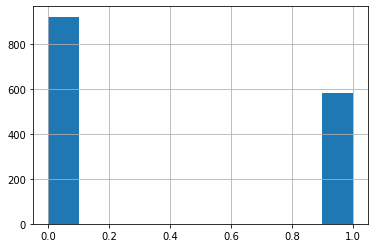

In [7]:
_ = df['Class'].hist()

# Baseline

Get embedding

In [8]:
with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in df['Text']])
    
doc_vectors.shape

(1500, 300)

Splitting data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, df['Class'],
                                                    test_size=0.1, random_state=1)

LinearSVC

In [10]:
svc = LinearSVC(random_state=1)
svc.fit(X_train, y_train)
print(f"Accuracy: {svc.score(X_test, y_test) * 100:.3f}%", )
svc.fit(doc_vectors, df['Class'])

Accuracy: 83.333%


LinearSVC(random_state=1)

### Predict test

In [11]:
df_sample.head()

,ID,Class
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


In [12]:
df_test.head()

,ID,Text,Class
0,1,Ye bhi illegal immigrant lag rahi hai -- NRC r...,?
1,2,Yeah I asked someone about her skirt today and...,?
2,3,You need to clean your SELECTIVE HEARING COBWE...,?
3,4,It easy to complain and criticize with no offe...,?
4,5,Guess the send-them-back policy of your friend...,?


In [13]:
with nlp.disable_pipes():
    doc_vectors_test = np.array([nlp(text).vector for text in df_test.Text])
doc_vectors_test.shape

(500, 300)

In [14]:
predict = svc.predict(doc_vectors_test)
predict[:5]

array([1, 1, 0, 1, 1], dtype=int64)

In [15]:
df_test['Class'] = predict
df_test.head()

,ID,Text,Class
0,1,Ye bhi illegal immigrant lag rahi hai -- NRC r...,1
1,2,Yeah I asked someone about her skirt today and...,1
2,3,You need to clean your SELECTIVE HEARING COBWE...,0
3,4,It easy to complain and criticize with no offe...,1
4,5,Guess the send-them-back policy of your friend...,1


In [16]:
df_test.drop('Text', axis=1).to_csv('test_predict.csv', index=False, sep=',')

Kaggle score: 0.78333

# Prepare data

In [17]:
test_text = df.iloc[0]['Text']
print(test_text)

Trump supporters needed to say the 4 Democrats socialist Squad are racist towards Trump America supporter. America has freedom of speech and it was a Trump hyper rally not a Socialist Democratic squad rally. The rally said send her back the one not migrants Socialist Democratic


In [144]:
#RandomOverSampler - for imbalanced target 

tokenizer

In [18]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

Custom Transformer

In [19]:
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

TF-IDF and Bag of Words transformers

In [123]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3, ngram_range=(1,2))

Split data

In [171]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'], 
    df['Class'], 
    test_size=0.2, 
    stratify=df['Class'], 
    random_state=42
)

In [172]:
def saveTest(pipe, df_test, name_file):
    pipe.fit(df['Text'], df['Class'])
    predict = pipe.predict(df_test['Text'])
    df_test['Class'] = predict
    df_test.drop('Text', axis=1).to_csv(name_file+'.csv', index=False, sep=',')
    print('Complete')

<b>Creating a Pipeline and Generating the Model</b>

TF-IDF

In [173]:
classifier = RandomForestClassifier(random_state=42, n_estimators=100, min_samples_split=5)
classifier = LogisticRegression(
    random_state=42, 
    penalty='elasticnet', 
    solver='saga', 
    l1_ratio=.05,
    max_iter=200
) # kaggle 0.81 0.84

pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('RUS', RandomOverSampler()),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)
predicted = pipe.predict(X_test)

# Model Accuracy
print("TF-IDF Accuracy: \t", sklearn.metrics.accuracy_score(y_test, predicted))
print("TF-IDF Precision: \t", sklearn.metrics.precision_score(y_test, predicted))
print("TF-IDF Recall: \t\t", sklearn.metrics.recall_score(y_test, predicted))
print("TF-IDF f1: \t\t", sklearn.metrics.f1_score(y_test, predicted))

TF-IDF Accuracy: 	 0.8566666666666667
TF-IDF Precision: 	 0.8016528925619835
TF-IDF Recall: 		 0.8362068965517241
TF-IDF f1: 		 0.8185654008438819


In [174]:
saveTest(pipe, df_test, 'test_predict2')

Complete


Bag of word

In [176]:
pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('RUS', RandomOverSampler()),
                 ('classifier', classifier)])

# model generation
pipe2.fit(X_train,y_train)
predicted = pipe2.predict(X_test)

# Model Accuracy
print("Bag of Words Accuracy: \t", sklearn.metrics.accuracy_score(y_test, predicted))
print("Bag of Words Precision: ", sklearn.metrics.precision_score(y_test, predicted))
print("Bag of Words Recall: \t", sklearn.metrics.recall_score(y_test, predicted))
print("Bag of Words f1: \t", sklearn.metrics.f1_score(y_test, predicted))

Bag of Words Accuracy: 	 0.86
Bag of Words Precision:  0.8303571428571429
Bag of Words Recall: 	 0.8017241379310345
Bag of Words f1: 	 0.8157894736842104


C:\Users\Ирик\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [160]:
saveTest(pipe, df_test, 'test_predict3')

Complete


- logreg TF-IDF = 0.84416
- logreg Bog = 0.846

Embeddings